<a href="https://colab.research.google.com/github/tanyaoley/colab/blob/master/06_01_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендаьельных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import scale

In [12]:
colab = True 
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')
if colab:
    df = pd.read_csv('/content/drive/My Drive/Data/amazon.csv.gz')
else:
    df = pd.read_csv('/home/tanya/data/amazon.csv.gz')
df.head()
# ACTION - это целевой признак

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовть [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


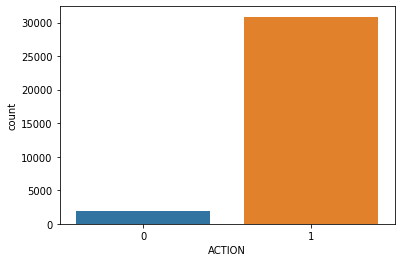

In [13]:
print(df['ACTION'].mean())
sns.countplot('ACTION', data=df)

In [14]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [0]:
X = df.drop(['ACTION'], axis=1)
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

              precision    recall  f1-score   support

           0       0.22      0.03      0.05      1534
           1       0.94      0.99      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.58      0.51      0.51     26216
weighted avg       0.90      0.94      0.91     26216



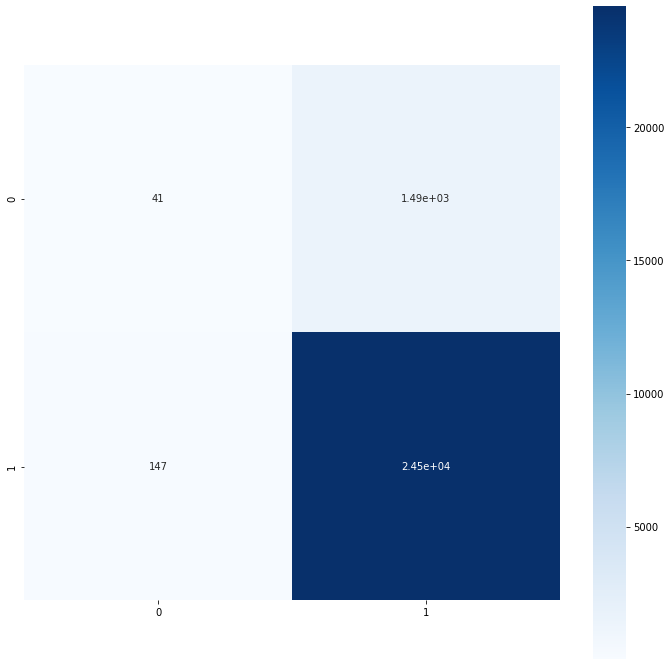

In [16]:
clf = KNeighborsClassifier(n_neighbors=5, p=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype('int')

print(classification_report(y_test, y_pred))

plt.figure(figsize=(12,12))
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')


##много ошибок первого рода те ложных срабатываний(доступ запрещен для тех, кому должен быть разрешен)


При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

1


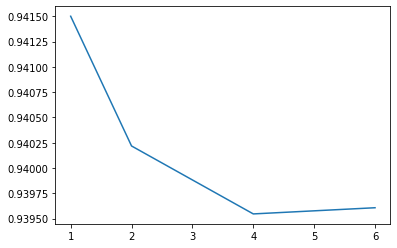

In [17]:
X_scaled = scale(X)
cv = KFold(n_splits=5, shuffle=False)

p_vals =[1,2,4,6]
quality_by_p = [
    cross_val_score(KNeighborsClassifier(n_neighbors=10, p=p), X_scaled, y, cv=cv).mean()
    for p in p_vals
]

print(p_vals[np.argmax(quality_by_p)])
plt.plot(p_vals, quality_by_p)

# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

In [18]:
from collections import Counter
data = pd.DataFrame(index=df.index)
for col_name in df.columns:
    if col_name == 'ACTION':
        continue
    else:
      count_in_col = Counter(df[col_name])
      data['counter_{}'.format(col_name)] = [count_in_col[x] for x in df[col_name]]
      successes_in_col = Counter(df[df['ACTION'].astype(str).str.contains('1') == True][col_name])
      data['successes_{}'.format(col_name)] = [successes_in_col[x] for x in df[col_name]]
      data['ratio_{}'.format(col_name)] = (data['counter_{}'.format(col_name)]+1) / (data['successes_{}'.format(col_name)]+2)
data 

,counter_RESOURCE,successes_RESOURCE,ratio_RESOURCE,counter_MGR_ID,successes_MGR_ID,ratio_MGR_ID,counter_ROLE_ROLLUP_1,successes_ROLE_ROLLUP_1,ratio_ROLE_ROLLUP_1,counter_ROLE_ROLLUP_2,successes_ROLE_ROLLUP_2,ratio_ROLE_ROLLUP_2,counter_ROLE_DEPTNAME,successes_ROLE_DEPTNAME,ratio_ROLE_DEPTNAME,counter_ROLE_TITLE,successes_ROLE_TITLE,ratio_ROLE_TITLE,counter_ROLE_FAMILY_DESC,successes_ROLE_FAMILY_DESC,ratio_ROLE_FAMILY_DESC,counter_ROLE_FAMILY,successes_ROLE_FAMILY,ratio_ROLE_FAMILY,counter_ROLE_CODE,successes_ROLE_CODE,ratio_ROLE_CODE
0,3,3,0.800000,55,55,0.982456,21407,20320,1.053440,4424,4230,1.045605,72,69,1.028169,3583,3467,1.033151,6896,6437,1.071129,10980,10347,1.061069,3583,3467,1.033151
1,30,29,1.000000,10,10,0.916667,21407,20320,1.053440,3945,3823,1.031634,159,142,1.111111,81,78,1.025000,12,12,0.928571,1287,1220,1.054010,81,78,1.025000
2,2,2,0.750000,3,3,0.800000,184,169,1.081871,184,169,1.081871,546,504,1.081028,1256,1117,1.123324,33,31,1.030303,2636,2393,1.101044,1256,1117,1.123324
3,1,1,0.666667,62,62,0.984375,21407,20320,1.053440,3945,3823,1.031634,190,188,1.005263,4649,4279,1.086195,1244,1189,1.045340,10980,10347,1.061069,4649,4279,1.086195
4,8,8,0.900000,9,9,0.909091,276,257,1.069498,138,121,1.130081,45,34,1.277778,75,65,1.134328,19,18,1.000000,362,303,1.190164,75,65,1.134328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,51,46,1.083333,29,28,1.000000,21407,20320,1.053440,4424,4230,1.045605,190,188,1.005263,4649,4279,1.086195,1244,1189,1.045340,10980,10347,1.061069,4649,4279,1.086195
32765,2,2,0.750000,9,9,0.909091,721,695,1.035868,721,695,1.035868,54,54,0.982143,24,24,0.961538,5,5,0.857143,224,219,1.018100,24,24,0.961538
32766,161,155,1.031847,5,5,0.857143,21407,20320,1.053440,2641,2521,1.047166,42,42,0.977273,3,3,0.800000,2,2,0.750000,78,76,1.012821,3,3,0.800000
32767,7,7,0.888889,16,11,1.307692,275,202,1.352941,257,185,1.379679,659,570,1.153846,394,360,1.091160,244,210,1.155660,1318,1137,1.158033,394,360,1.091160


Проверьте какое качество теперь получается на кроссвалидации для новых данных.

In [0]:
X = data
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)
X_scaled = scale(X)


              precision    recall  f1-score   support

           0       0.47      0.11      0.17      1534
           1       0.95      0.99      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.71      0.55      0.57     26216
weighted avg       0.92      0.94      0.92     26216



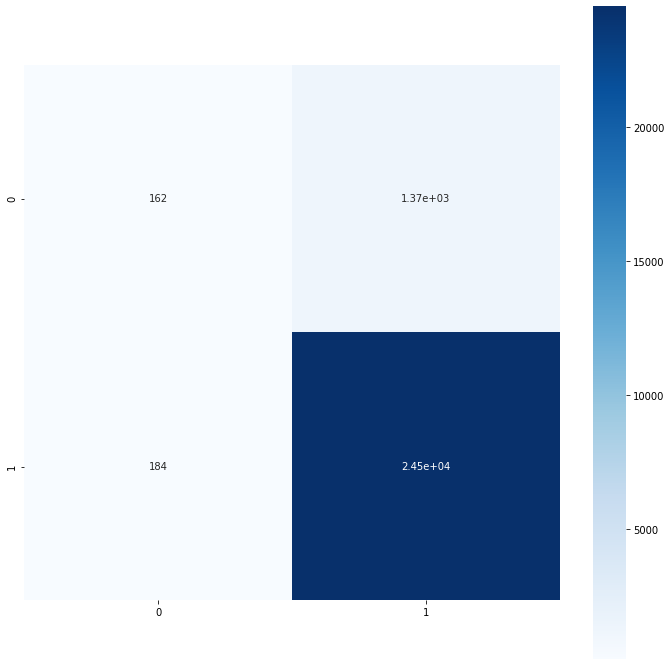

In [20]:
clf = KNeighborsClassifier(n_neighbors=5, p=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype('int')

print(classification_report(y_test, y_pred))

plt.figure(figsize=(12,12))
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')


- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

In [0]:
#плохое значение recaall при нулевых значениях(сильно меньше единицы), но лучше, чем было 

# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [0]:
df_combo = df.copy()


In [0]:
data_combo = pd.DataFrame(index=df_combo.index)
old_col = df_combo.columns
for col_name in df_combo.columns:
    if col_name == 'ACTION':
        continue
    else:
      if col_name in old_col:
        for i in range(list(old_col).index(col_name)+1, len(old_col)):
          second_column= old_col[i]
          df_combo["{0}+{1}".format(col_name,second_column)] = df_combo[col_name].astype(str).str.cat(df_combo[second_column].astype(str),sep = "#")

In [33]:
df_combo

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,RESOURCE+MGR_ID,RESOURCE+ROLE_ROLLUP_1,RESOURCE+ROLE_ROLLUP_2,RESOURCE+ROLE_DEPTNAME,RESOURCE+ROLE_TITLE,RESOURCE+ROLE_FAMILY_DESC,RESOURCE+ROLE_FAMILY,RESOURCE+ROLE_CODE,MGR_ID+ROLE_ROLLUP_1,MGR_ID+ROLE_ROLLUP_2,MGR_ID+ROLE_DEPTNAME,MGR_ID+ROLE_TITLE,MGR_ID+ROLE_FAMILY_DESC,MGR_ID+ROLE_FAMILY,MGR_ID+ROLE_CODE,ROLE_ROLLUP_1+ROLE_ROLLUP_2,ROLE_ROLLUP_1+ROLE_DEPTNAME,ROLE_ROLLUP_1+ROLE_TITLE,ROLE_ROLLUP_1+ROLE_FAMILY_DESC,ROLE_ROLLUP_1+ROLE_FAMILY,ROLE_ROLLUP_1+ROLE_CODE,ROLE_ROLLUP_2+ROLE_DEPTNAME,ROLE_ROLLUP_2+ROLE_TITLE,ROLE_ROLLUP_2+ROLE_FAMILY_DESC,ROLE_ROLLUP_2+ROLE_FAMILY,ROLE_ROLLUP_2+ROLE_CODE,ROLE_DEPTNAME+ROLE_TITLE,ROLE_DEPTNAME+ROLE_FAMILY_DESC,ROLE_DEPTNAME+ROLE_FAMILY,ROLE_DEPTNAME+ROLE_CODE,ROLE_TITLE+ROLE_FAMILY_DESC,ROLE_TITLE+ROLE_FAMILY,ROLE_TITLE+ROLE_CODE,ROLE_FAMILY_DESC+ROLE_FAMILY,ROLE_FAMILY_DESC+ROLE_CODE,ROLE_FAMILY+ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908,39353#85475,39353#117961,39353#118300,39353#123472,39353#117905,39353#117906,39353#290919,39353#117908,85475#117961,85475#118300,85475#123472,85475#117905,85475#117906,85475#290919,85475#117908,117961#118300,117961#123472,117961#117905,117961#117906,117961#290919,117961#117908,118300#123472,118300#117905,118300#117906,118300#290919,118300#117908,123472#117905,123472#117906,123472#290919,123472#117908,117905#117906,117905#290919,117905#117908,117906#290919,117906#117908,290919#117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539,17183#1540,17183#117961,17183#118343,17183#123125,17183#118536,17183#118536,17183#308574,17183#118539,1540#117961,1540#118343,1540#123125,1540#118536,1540#118536,1540#308574,1540#118539,117961#118343,117961#123125,117961#118536,117961#118536,117961#308574,117961#118539,118343#123125,118343#118536,118343#118536,118343#308574,118343#118539,123125#118536,123125#118536,123125#308574,123125#118539,118536#118536,118536#308574,118536#118539,118536#308574,118536#118539,308574#118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880,36724#14457,36724#118219,36724#118220,36724#117884,36724#117879,36724#267952,36724#19721,36724#117880,14457#118219,14457#118220,14457#117884,14457#117879,14457#267952,14457#19721,14457#117880,118219#118220,118219#117884,118219#117879,118219#267952,118219#19721,118219#117880,118220#117884,118220#117879,118220#267952,118220#19721,118220#117880,117884#117879,117884#267952,117884#19721,117884#117880,117879#267952,117879#19721,117879#117880,267952#19721,267952#117880,19721#117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322,36135#5396,36135#117961,36135#118343,36135#119993,36135#118321,36135#240983,36135#290919,36135#118322,5396#117961,5396#118343,5396#119993,5396#118321,5396#240983,5396#290919,5396#118322,117961#118343,117961#119993,117961#118321,117961#240983,117961#290919,117961#118322,118343#119993,118343#118321,118343#240983,118343#290919,118343#118322,119993#118321,119993#240983,119993#290919,119993#118322,118321#240983,118321#290919,118321#118322,240983#290919,240983#118322,290919#118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325,42680#5905,42680#117929,42680#117930,42680#119569,42680#119323,42680#123932,42680#19793,42680#119325,5905#117929,5905#117930,5905#119569,5905#119323,5905#123932,5905#19793,5905#119325,117929#117930,117929#119569,117929#119323,117929#123932,117929#19793,117929#119325,117930#119569,117930#119323,117930#123932,117930#19793,117930#119325,119569#119323,119569#123932,119569#19793,119569#119325,119323#123932,119323#19793,119323#119325,123932#19793,123932#119325,19793#119325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,1,23497,16971,117961,118300,119993,118321,240983,290919,118322,23497#16971,23497#117961,23497#118300,23497

In [29]:
df_combo_res = pd.DataFrame(index=df.index)
for col_name in df_combo.columns:
    if col_name == 'ACTION':
        continue
    else:
      count_in_col = Counter(df_combo[col_name])
      df_combo_res['counter_{}'.format(col_name)] = [count_in_col[x] for x in df_combo[col_name]]
      successes_in_col = Counter(df_combo[df_combo['ACTION'].astype(str).str.contains('1') == True][col_name])
      df_combo_res['successes_{}'.format(col_name)] = [successes_in_col[x] for x in df_combo[col_name]]
      df_combo_res['ratio_{}'.format(col_name)] = (df_combo_res['counter_{}'.format(col_name)]+1) / (df_combo_res['successes_{}'.format(col_name)]+2)
df_combo_res 

,counter_RESOURCE,successes_RESOURCE,ratio_RESOURCE,counter_MGR_ID,successes_MGR_ID,ratio_MGR_ID,counter_ROLE_ROLLUP_1,successes_ROLE_ROLLUP_1,ratio_ROLE_ROLLUP_1,counter_ROLE_ROLLUP_2,successes_ROLE_ROLLUP_2,ratio_ROLE_ROLLUP_2,counter_ROLE_DEPTNAME,successes_ROLE_DEPTNAME,ratio_ROLE_DEPTNAME,counter_ROLE_TITLE,successes_ROLE_TITLE,ratio_ROLE_TITLE,counter_ROLE_FAMILY_DESC,successes_ROLE_FAMILY_DESC,ratio_ROLE_FAMILY_DESC,counter_ROLE_FAMILY,successes_ROLE_FAMILY,ratio_ROLE_FAMILY,counter_ROLE_CODE,successes_ROLE_CODE,ratio_ROLE_CODE,counter_RESOURCE+MGR_ID,successes_RESOURCE+MGR_ID,ratio_RESOURCE+MGR_ID,counter_RESOURCE+ROLE_ROLLUP_1,successes_RESOURCE+ROLE_ROLLUP_1,ratio_RESOURCE+ROLE_ROLLUP_1,counter_RESOURCE+ROLE_ROLLUP_2,successes_RESOURCE+ROLE_ROLLUP_2,ratio_RESOURCE+ROLE_ROLLUP_2,counter_RESOURCE+ROLE_DEPTNAME,successes_RESOURCE+ROLE_DEPTNAME,ratio_RESOURCE+ROLE_DEPTNAME,counter_RESOURCE+ROLE_TITLE,...,ratio_ROLE_ROLLUP_2+ROLE_TITLE,counter_ROLE_ROLLUP_2+ROLE_FAMILY_DESC,successes_ROLE_ROLLUP_2+ROLE_FAMILY_DESC,ratio_ROLE_ROLLUP_2+ROLE_FAMILY_DESC,counter_ROLE_ROLLUP_2+ROLE_FAMILY,successes_ROLE_ROLLUP_2+ROLE_FAMILY,ratio_ROLE_ROLLUP_2+ROLE_FAMILY,counter_ROLE_ROLLUP_2+ROLE_CODE,successes_ROLE_ROLLUP_2+ROLE_CODE,ratio_ROLE_ROLLUP_2+ROLE_CODE,counter_ROLE_DEPTNAME+ROLE_TITLE,successes_ROLE_DEPTNAME+ROLE_TITLE,ratio_ROLE_DEPTNAME+ROLE_TITLE,counter_ROLE_DEPTNAME+ROLE_FAMILY_DESC,successes_ROLE_DEPTNAME+ROLE_FAMILY_DESC,ratio_ROLE_DEPTNAME+ROLE_FAMILY_DESC,counter_ROLE_DEPTNAME+ROLE_FAMILY,successes_ROLE_DEPTNAME+ROLE_FAMILY,ratio_ROLE_DEPTNAME+ROLE_FAMILY,counter_ROLE_DEPTNAME+ROLE_CODE,successes_ROLE_DEPTNAME+ROLE_CODE,ratio_ROLE_DEPTNAME+ROLE_CODE,counter_ROLE_TITLE+ROLE_FAMILY_DESC,successes_ROLE_TITLE+ROLE_FAMILY_DESC,ratio_ROLE_TITLE+ROLE_FAMILY_DESC,counter_ROLE_TITLE+ROLE_FAMILY,successes_ROLE_TITLE+ROLE_FAMILY,ratio_ROLE_TITLE+ROLE_FAMILY,counter_ROLE_TITLE+ROLE_CODE,successes_ROLE_TITLE+ROLE_CODE,ratio_ROLE_TITLE+ROLE_CODE,counter_ROLE_FAMILY_DESC+ROLE_FAMILY,successes_ROLE_FAMILY_DESC+ROLE_FAMILY,ratio_ROLE_FAMILY_DESC+ROLE_FAMILY,counter_ROLE_FAMILY_DESC+ROLE_CODE,successes_ROLE_FAMILY_DESC+ROLE_CODE,ratio_ROLE_FAMILY_DESC+ROLE_CODE,counter_ROLE_FAMILY+ROLE_CODE,successes_ROLE_FAMILY+ROLE_CODE,ratio_ROLE_FAMILY+ROLE_CODE
0,3,3,0.800000,55,55,0.982456,21407,20320,1.053440,4424,4230,1.045605,72,69,1.028169,3583,3467,1.033151,6896,6437,1.071129,10980,10347,1.061069,3583,3467,1.033151,3,3,0.800000,3,3,0.800000,3,3,0.800000,1,1,0.666667,2,...,1.011111,1089,1027,1.059281,1695,1622,1.044335,454,448,1.011111,22,22,0.958333,55,52,1.037037,62,59,1.032787,22,22,0.958333,2607,2528,1.030830,3583,3467,1.033151,3583,3467,1.033151,6844,6392,1.070535,2607,2528,1.030830,3583,3467,1.033151
1,30,29,1.000000,10,10,0.916667,21407,20320,1.053440,3945,3823,1.031634,159,142,1.111111,81,78,1.025000,12,12,0.928571,1287,1220,1.054010,81,78,1.025000,1,1,0.666667,26,25,1.000000,11,10,1.000000,1,1,0.666667,1,...,0.952381,5,5,0.857143,225,207,1.081340,19,19,0.952381,5,5,0.857143,5,5,0.857143,39,38,1.000000,5,5,0.857143,12,12,0.928571,81,78,1.025000,81,78,1.025000,12,12,0.928571,12,12,0.928571,81,78,1.025000
2,2,2,0.750000,3,3,0.800000,184,169,1.081871,184,169,1.081871,546,504,1.081028,1256,1117,1.123324,33,31,1.030303,2636,2393,1.101044,1256,1117,1.123324,1,1,0.666667,2,2,0.750000,2,2,0.750000,2,2,0.750000,2,...,1.130435,2,2,0.750000,124,111,1.106195,51,44,1.130435,184,160,1.141975,2,2,0.750000,295,259,1.134100,184,160,1.141975,2,2,0.750000,1256,1117,1.123324,1256,1117,1.123324,28,26,1.035714,2,2,0.750000,1256,1117,1.123324
3,1,1,0.666667,62,62,0.984375,21407,20320,1.053440,3945,3823,1.031634,190,188,1.005263,4649,4279,1.086195,1244,1189,1.045340,10980,10347,1.061069,4649,4279,1.086195,1,1,0.666667,1,1,0.666667,1,1,0.666667,1,1,0.666667,1,...,1.049858,255,252,1.007874,1701,1647,1.032141,736,700,1.049858,100,98,1.010000,58,57,1.000000,156,154,1.006410,100,98,1.010000,531,508,1.043137,4649,4279,1.086195,4649,4279,1.086195,1244,1189,1.045340,53

              precision    recall  f1-score   support

           0       0.41      0.05      0.09      1534
           1       0.94      1.00      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.68      0.52      0.53     26216
weighted avg       0.91      0.94      0.92     26216



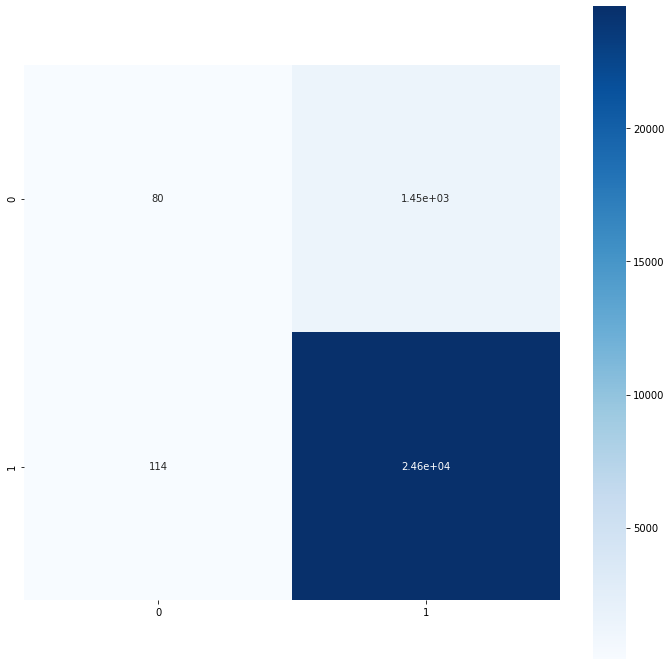

In [34]:
X = df_combo_res
y = df_combo['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

clf = KNeighborsClassifier(n_neighbors=10, p=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype('int')

print(classification_report(y_test, y_pred))

plt.figure(figsize=(12,12))
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!

In [0]:
#качество не улучшилось